In [81]:
import rasterio
from rasterio import features, fill
from shapely.geometry import box
import geopandas as gpd
import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation
import time
from scipy import ndimage
import gc
import os
from matplotlib import pyplot

In [2]:
#file_path = r"D:\___rasterio_testing\orto4.tif"
shape_path = r"D:\___WodyPolskie\clipping_rastry\gora_buffered.shp"
tile_path = r"D:\1111Przetwarzanie\PL1992_5000_1.shp"
#tile_path = r"D:\___rasterio_testing\outline.shp"
out_folder = r"D:\___WodyPolskie\clipping_rastry\out"

folder_path = r"D:\___WodyPolskie\clipping_rastry\test"
rasters = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")]

In [42]:
for file_path in rasters[:1]:

    print("Filling: ", file_path.split("\\")[-1])

    src = rasterio.open(file_path)

    new_time = time.time()
    raster_name = file_path.split("\\")[-1].split(".")[0]
    #raster_name = "M-33-23-B-a-1-1"

    # Load vector data
    vector = gpd.read_file(shape_path)
    tile = gpd.read_file(tile_path)
    selected_tile = tile[tile["godlo"] == raster_name]

    new_time1 = time.time()
    print("time to load vectors:", new_time1 - new_time)

    # Create clipping geometry from raster bounds
    clip_geom = box(src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)
    clipped = vector.clip(clip_geom)
    clipped_buffered = clipped.buffer(15)

    clipped_vector = clipped_buffered.clip(selected_tile)
    clipped_vector_not_buffered = clipped.clip(selected_tile)

    # Rasterize vector shapes to create shape mask
    geom = [shapes for shapes in clipped_vector.geometry]
    not_buffered_geom = [shapes for shapes in clipped_vector_not_buffered.geometry]

    new_time2 = time.time()
    print("time to prepare vectors:", new_time2 - new_time1)
    
    # Read original mask and create combined mask of all valid data
    raster_mask = src.read_masks()

    new_time3 = time.time()
    print("time to load masks:", new_time3 - new_time2)

    # Invert mask: 1 = hole, 255 = valid data
    switched_mask = np.where(raster_mask[0] == 0, 1, raster_mask[0])

    # Create shape mask from vector geometries
    shape_mask = features.rasterize(shapes = geom, out_shape = (src.height, src.width), transform = src.transform, all_touched = True, fill = 0, dtype = rasterio.uint8)
    non_buff_shape_mask = features.rasterize(shapes = not_buffered_geom, out_shape = (src.height, src.width), transform = src.transform, all_touched = True, fill = 0, dtype = rasterio.uint8)

    # Combine both masks: 255 = valid data, 0 = hole, 1 = outside polygon, then turn to boolean
    combined_mask = (switched_mask * shape_mask)

    combined_switched = np.where((combined_mask == 0) | (combined_mask == 1), combined_mask^1, combined_mask)
    
    del geom, clip_geom, clipped, clipped_buffered, clipped_vector, raster_mask, switched_mask, shape_mask, combined_mask
    gc.collect()

    combined_bool = np.where(combined_switched == 0, 0, 1)

    new_time4 = time.time()
    print("time to prepare masks:", new_time4 - new_time3)

Filling:  M-33-21-B-d-2-4.tif
time to load vectors: 0.07053160667419434
time to prepare vectors: 0.01350545883178711
time to load masks: 35.42562007904053
time to prepare masks: 18.688979625701904


In [45]:
factor = 10
image_full = src.read()
bands, H, W = image_full.shape
holes_full = (combined_bool == 0)

H_trim = (H // factor) * factor
W_trim = (W // factor) * factor

image_trim = image_full[:, :H_trim, :W_trim]
holes_trim = combined_bool[:H_trim, :W_trim]

image_lr = image_trim[:, ::factor, ::factor]
H_lr, W_lr = image_lr.shape[1], image_lr.shape[2]

holes_lr = holes_trim.reshape(
    H_lr, factor,
    W_lr, factor
).any(axis = (1, 3))

combined_bool_lr = np.where(holes_lr, 1, 0).astype(np.uint8)

max_search_distance_lr = 200 // factor

new_time7 = time.time()
print("time to subsample raster:", new_time7 - new_time4)

time to subsample raster: 220.18848276138306


In [114]:
def fill_holes_locally(
        clipped_image: np.ndarray,
        combined_mask_lr: np.ndarray,
        max_search_distance: int,
        margin: int
):
    
    print("Started filling")
    image = clipped_image
    del clipped_image
    gc.collect()

    bands, height, width = image.shape
    
    structure = np.array(
        [[0,1,0],
         [1,1,1],
         [0,1,0]],
        dtype=bool
    )

    new_time7 = time.time()

    labels, num = ndimage.label(combined_mask_lr == 0, structure=structure)
    print(f"Found {num} hole components to fill")

    new_time8 = time.time()
    print("time label holes:", new_time8 - new_time7)
    
    #for label_id in range(1, n_reduced + 1):
    for label_id in range(1, num + 1):
        component_mask = labels == label_id
        if not component_mask.any():
            print("Empty component, skipping")
            continue

        print(f"Filling component {label_id} / {num}")

        # Find bounding box of the component
        rows, cols = np.where(component_mask)
        rmin, rmax = rows.min(), rows.max()
        cmin, cmax = cols.min(), cols.max()

        # Expand bounding box by margin
        r0 = max(rmin - margin, 0)
        r1 = min(rmax + margin + 1, height)
        c0 = max(cmin - margin, 0)
        c1 = min(cmax + margin + 1, width)

        # Extract local window
        local_data = image[:, r0:r1, c0:c1]
        local_mask = combined_mask_lr[r0:r1, c0:c1]
        mask_expanded = binary_dilation(local_mask == 0, iterations = 2)
        local_mask = np.where(mask_expanded, 0, 1).astype(np.uint8)

        # Skip if no holes in local mask
        if not (local_mask == 0).any():
            print("No holes in component, skipping")
            continue

        # Run fillnodata per band in local window
        for b in range(bands):
            band = local_data[b]
            band_filled = fill.fillnodata(
                band,
                mask=local_mask,
                max_search_distance=max_search_distance,
                smoothing_iterations=0
            )
            
            local_data[b] = band_filled
    
        smoothed = gaussian_filter(local_data, sigma = (0, 1, 1))
        final = np.where(local_mask == 0, smoothed, local_data)

        #rgb = np.transpose(final, (1, 2, 0))
        #pyplot.imshow(rgb.astype(np.uint8))
        #pyplot.show()
        #pyplot.close()


        # Put filled data back into main array
        image[:, r0:r1, c0:c1] = final
    """
    new_time10 = time.time()
    holes_mask = (combined_bool == 0)

    smoothed_full = gaussian_filter(image, sigma = (0, 10, 10))

    image = np.where(holes_mask[np.newaxis, :, :],
                     smoothed_full,
                     image
    )

    new_time11 = time.time()
    print("time to smooth images:", new_time11 - new_time10)
    """
    return image

In [115]:
new_time7 = time.time()
# Fill holes locally
filled = fill_holes_locally(
    clipped_image=image_lr,
    combined_mask_lr=combined_bool_lr,
    max_search_distance=max_search_distance_lr,
    margin=3
)


new_time10 = time.time()
print("time fill and smooth holes:", new_time10 - new_time7)

Started filling
Found 17 hole components to fill
time label holes: 0.10620975494384766
Filling component 1 / 17
Filling component 2 / 17
Filling component 3 / 17
Filling component 4 / 17
Filling component 5 / 17
Filling component 6 / 17
Filling component 7 / 17
Filling component 8 / 17
Filling component 9 / 17
Filling component 10 / 17
Filling component 11 / 17
Filling component 12 / 17
Filling component 13 / 17
Filling component 14 / 17
Filling component 15 / 17
Filling component 16 / 17
Filling component 17 / 17
time fill and smooth holes: 1.541215181350708


In [110]:
#45 seconds
new_time8 = time.time()


filled_lr_up = filled.repeat(factor, axis = 1).repeat(factor, axis = 2)

holes_full_trim = holes_full[:H_trim, :W_trim]

image_full[:, :H_trim, :W_trim] = np.where(
    holes_full_trim[np.newaxis, :, :],
    filled_lr_up,
    image_full[:, :H_trim, :W_trim]
)

new_time9 = time.time()
print("time to join data back in:", new_time9 - new_time8)

time to join data back in: 46.83255124092102


In [111]:
#15 seconds
mask_bool = non_buff_shape_mask.astype(bool)
nodata = src.nodata if src.nodata is not None else 0
clipped_image = np.where(mask_bool, image_full, nodata).astype(filled.dtype)

new_time6 = time.time()
print("time to clip raster:", new_time6 - new_time9)

time to clip raster: 16.11703133583069


In [112]:
#20 seconds
out_meta = src.meta.copy()
out_meta.update({
    "height": clipped_image.shape[1],
    "width": clipped_image.shape[2],
    "count": clipped_image.shape[0],
    "dtype": np.uint8,
    #"nodata": nodata
    "compress": "LZW",
    "tiled": True,
    "blockxsize": 512,
    "blockysize": 512,
    "BIGTIFF": "IF_SAFER",
    "SPARSE_OK": True
})

file_name = file_path.split("\\")[-1]
out_path = os.path.join(out_folder, file_name)

with rasterio.open(
    out_path,
    "w",
    **out_meta
) as dst:
    for idx, array in enumerate(clipped_image, start=1):
        dst.write(array, idx)


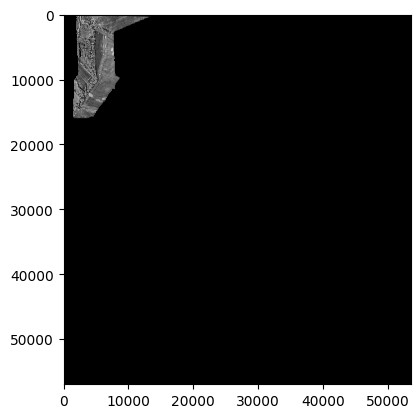

In [60]:
pyplot.imshow(image_full[0], cmap = "gray")
pyplot.show()
pyplot.close()